# Automate cellulaire: documentation, tests et exemples

In [1]:
%pylab inline
import cellular_automaton as ca
import random

Populating the interactive namespace from numpy and matplotlib


# 1) Module cellular_automaton

## Constructeur

La signature : __init__(self, initial_state, transition_matrix, cols = [ ], direction = ['random'], max_range = None, step_by_step = True, log_level = 2, log_file_name = 'activity.log' )

Les arguments du constructeur sont les suivants:

* initial_state : C'est l'état initial du système dans un numpy array. Les dimensions peuvent être n'importe lesquelles mais on s'attend à une matrice carrée. Si on veut représenter l'espèce 1 par 1 et qu'au départ une cellule de type 1 est en haut à gauche alors on s'attend à trouver la valeur 1 aux coordonnées (0,0) de la matrice initial_state. Certains messages d'information seront lancés à partir de la méthode privée check_initial_state(n_spieces, initial_state = initial_state). Les cellules seront indexées à partir de 0 où 0 sera indiféremment le vide ou l'espèce de type 0.

* transition_matrix : c'est une matrice carrée de dimensions $(n\_spieces^2,n\_spieces^2)$. Elle décrit les probabilités de transition d'un couple vers un autre couple. On s'attend à une matice stochastique symétrique. Les vérifications et modifications relatives à l'input seront effectués dans la méthode privée check_transition_matrix(transition_matrix = transition_matrix).
    - Les coefficients négatifs seront pris en valeur absolue.
    - Les lignes dont la somme ne fait pas 1 seront renormalisés (ie tous les coeeficients seront divisés par la somme).
    - Le cas non symétrique sera ignoré: le fait qu'une transition 1-2 -> x n'ait pas la même proba qu'une transition 2-1->x est étrange mais n'est pas absurde en soit.
    - Si la matrice n'est pas carrée ou si la dimension n'est pas $n\_spieces^2$, le programme lance une erreur.

* cols : (optionnel, default = None). Permet de spécifier le mapping index de l'espèce/ couleur associée. Si None le mapping sera laissé à la black box de matplotlib. Sinon doit être une liste/un array de dimension n_spieces. Un check de l'input est fait dans la méthode privée check_cols(cols =  cols, transition_matrix = transition_matrix)
    - Si la dimension de cols est $\ne$ n_spieces le mapping de Python par défault sera laissé.

* direction : (optionnel, default = ['random']). Permet de spécifier le sens des transitions effectués par l'automate. Si par nature les transitions devraient pouvoir s'effectuer partout, on peut ne souhaiter simuler que la gravié ou le vent. Doit être une liste d'élements parmi 'random', 'up', 'down', 'left', 'right', 'wind:right', 'wind:left', 'sky', 'gravity'.

* max_range : (optionnel, default = None) None si l'univers peut s'étendre à l'infini, en cas d'univers fini on s'attend à un entier positif au moins plus grand que la dimension de initial_state (dans le cas ou initial_state est une matrice carrée). Les modifications et erreurs seront traitées dans la métode privée check_max_range(initial_state, max_range).
    - Si la valeur n'est pas un entier, on tentera une conversion en entier
    - Si la valeur est négative, on prend la valeur absolue puis on convertit en entier
    - Dans le cas où la matrice initial_state n'est pas carrée, max_range sera mis à None
    - Dans le cas où éventuellement après conversion, max_range est à 0, il prendra finalement la valeur None.
    - *ATTENTION* : si max_range=None, alors le vide sera une espèce au sens des lois de transition, et sera encodée par 0
    
* step_by_step *: (optionnel, default = True) True pour qu'à chaque transition 1 unique couple soit choisi/ False pour faire des transitions sur quasi- toutes les cellules. L'input n'est pas checké mais un type non binaire (ie booléen ou 0/1) devrait faie bugger le programme.

* log_level (optionnel, default = 2) permet de définir le niveau de verbosité du logger:
    - 0 : DEBUG
    - 1 : INFO
    - 2 : WARNING
    - 3 : ERROR

* log_file_name (optionnel, default = 'activity.log') permet de fixer le nom du fichier de log.

Le programma a été conçu pour 2 configurations : 

1) Cellular_automaton ( initial_state : array (max_range x max_range)avec des entiers de 0 à n_spieces-1, transition_matrix : array ($n\_spieces^2,n\_spieces^2$) avec aux coordonnées $(x*n\_spieces+y, u*n\_spieces+v)$ la probabilité de transi (x,y) à (u,v), max_range un entier positif $\ge$ dim(initial_state) ). Ici l'univers est fini et 0 représente indifféremment l'espèce 0 ou le vide.

2) Cellular_automaton ( initial_state : array(dim0*dim1), transition_matrix : array ($n\_spieces^2,n\_spieces^2$) avec aux coordonnées $(x*n\_spieces+y, u*n\_spieces+v)$ la probabilité de transi (x,y) à (u,v), max_range= None, step_by_step = False). Ici, l'univers est infini, il peut évoluer dans une autre forme qu'un carré. 0 encode le vide dont la loi de transition est contenue dans les 1ères lignes (de 0 à n_spieces-1). Ici à chaque étape la plupart des cellules connaîtront une transition. On conseille de tester avec un nombre d'étapes relativement faible (beaucoup de transitions, donc temps d'éxecution long et visibilité sur les graphes moyenne avec l'expansion).

## Point sur les attributs

- all_states : liste contenant tous les états enregistrés du système (dont initial_state).
- current_state : dernier état enregistré du système (commence par pointer sur initial_state).
- max_range
- direction
- logger (associé au module)
- n_spieces : nombre d'espèces (racine de la dimension de transition_matrix)
- transition_matrix : pointe sur l'input du même nom (éventuellement renormalisé)
- cols : pointe sur l'input du même nom (éventuellement None)
- step_by_step

## Point sur les méthodes (publiques)

A ne pas utiliser :

__str__ : print l'objet et retourne une chaîne de caractère vide.

__del__: destructeur

Les autres seront décrites dans d'autres sections.
    


### Configuration 1

In [4]:
max_range3 = 10
initial_state3 = asarray([[1,1,0,2,1,2,1,2,0,0],
                          [1,1,0,2,1,2,1,2,0,0], 
                          [1,2,1,2,2,0,0,1,0,1], 
                          [2,2,0,2,1,1,2,0,0,1],
                          [1,2,1,2,2,0,0,1,0,1],
                          [2,2,0,2,1,1,2,0,0,1],
                          [2,2,0,2,1,1,2,0,0,1],
                          [1,1,0,2,1,2,1,2,0,0],
                          [1,1,0,2,1,2,1,2,0,0],
                          [1,2,1,2,2,0,0,1,0,1]]) 
transition_matrix3 = rand(3**2,3**2)
transition_matrix3 = array([e/sum(e) for e in transition_matrix3])
cols3 = ['white','red','blue']
step_by_step3 = True
direction3 = ['random']
cg3 = ca.Cellular_automaton (initial_state3, 
                             transition_matrix3, 
                             cols3,
                             direction3,
                             max_range3, 
                             step_by_step3, 
                             log_level=1, 
                             log_file_name = 'activity_logger3')
print(cg3)

Some of the transition laws in the transition matrix were not proba laws. The program has renormalized the laws
Some of the transition laws in the transition matrix were not proba laws. The program has renormalized the laws
Some of the transition laws in the transition matrix were not proba laws. The program has renormalized the laws


n_spieces:  3
max-range:  10
colors ['white', 'red', 'blue']
transition_matrix: 
[[0.1877462  0.0922705  0.00068892 0.08285708 0.18589863 0.16990189
  0.04003758 0.13502107 0.10557815]
 [0.14354449 0.06313872 0.06403044 0.09522362 0.2214586  0.13283766
  0.0531849  0.0954136  0.13116798]
 [0.18983159 0.1313111  0.03631552 0.1936693  0.22965233 0.07763339
  0.0709834  0.00395555 0.06664782]
 [0.21130721 0.1895375  0.0120307  0.04492606 0.02035061 0.15848513
  0.13198818 0.05331479 0.17805982]
 [0.07930231 0.01041422 0.12968024 0.3134778  0.00943882 0.06273294
  0.22903722 0.05883929 0.10707714]
 [0.17531432 0.19587434 0.10797576 0.10530417 0.10003597 0.02052301
  0.04410319 0.17883971 0.07202954]
 [0.01548597 0.07419022 0.02530795 0.19319093 0.16948391 0.04065664
  0.14696368 0.13668832 0.19803238]
 [0.20437788 0.18811245 0.00430165 0.00112141 0.11627139 0.11297151
  0.18203365 0.15719484 0.03361521]
 [0.16285154 0.14570035 0.0721987  0.16204193 0.01044419 0.13641134
  0.00560079 0.2042

### Configuration 2

In [5]:
n_spieces2 = 3 #0,1 et 2
max_range2 = None 
initial_state2 = asarray([ [1,1,0], [1,2,1], [2,2,0], [0,0,0] ]) 
transition_matrix2 = rand(n_spieces2**2,n_spieces2**2)
transition_matrix2 = array([e/sum(e) for e in transition_matrix2])
direction2 = ['random']
cols2 = ['white','red','blue']
step_by_step2 = False
cg2 = ca.Cellular_automaton (initial_state2, 
                             transition_matrix2, 
                             cols2, 
                             direction2,
                             max_range2, 
                             step_by_step2, 
                             log_level=1, 
                             log_file_name = 'activity_logger2')
#print(cg1)
print(cg2)

Some of the transition laws in the transition matrix were not proba laws. The program has renormalized the laws
Some of the transition laws in the transition matrix were not proba laws. The program has renormalized the laws
Some of the transition laws in the transition matrix were not proba laws. The program has renormalized the laws
Some of the transition laws in the transition matrix were not proba laws. The program has renormalized the laws


n_spieces:  3
max-range:  None
colors ['white', 'red', 'blue']
transition_matrix: 
[[0.11587336 0.14003125 0.15780179 0.00866341 0.13012081 0.13717788
  0.02384578 0.117844   0.16864173]
 [0.00986668 0.11149776 0.14338489 0.10778887 0.15732856 0.1766572
  0.16336694 0.06654832 0.06356077]
 [0.01238337 0.10716246 0.19385733 0.03193007 0.11525134 0.21890059
  0.22570302 0.06233902 0.03247281]
 [0.12888552 0.01736145 0.16829748 0.16166765 0.15287689 0.07769776
  0.17584904 0.03636824 0.08099598]
 [0.16049588 0.21893837 0.15749822 0.16984632 0.06799259 0.04099908
  0.10647498 0.01986143 0.05789314]
 [0.17956924 0.12264681 0.1653516  0.07076791 0.00773028 0.14815922
  0.03255117 0.17291842 0.10030536]
 [0.14279892 0.17138447 0.09463144 0.25356689 0.09396896 0.12755458
  0.04237592 0.00694897 0.06676986]
 [0.18708198 0.12104212 0.02462908 0.00629558 0.16547348 0.12505901
  0.07039741 0.19030087 0.10972047]
 [0.00585806 0.12858135 0.21521818 0.25698843 0.01916278 0.02689118
  0.04388976 0.199

## 2) A propos du fonctionnement de l'automate

### Le choix aléatoire des couples : module tinder_manager

6 attributs : 

- direction (typiquement celle de cellular_automaton)
- next_state (celle de cellular_automaton)
- up (True si up, random ou fly dans direction)
- down (True si down, gravity ou random dans direction)
- right (True si right, wind:right ou random dans direction)
- left (True si left, wind:left ou random dans direction)

#### Constructeur

__init__(self, next_state, direction)


#### Tinder_manager.get_next_tuple()

Cette méthode est celle pour choisir le couple de cellules à marier

#### Tinder_manager.get_next_tuples()

On boucle la méthode précédente

In [13]:
import tinder_manager as tm
tinder = tm.Tinder_manager(initial_state3, ['random'])

In [15]:
print('Config 1:')
print(tinder.get_next_tuple())

Config 1:
[((2, 3), (1, 3))]


In [16]:
print ('Config 2:')
print(tinder.get_next_tuples())

Config 2:
[((6, 1), (6, 0))]


### La transition aléatoire

Cette transition est assurée par la méthode next_step de signature :

cellular_automaton.next_step()

Si max_range = None alors on crée une matrice next_state initialisée à $dim(current\_state)[0]+2, dim(current\_state)[1]+2)$ ; avec partout sauf aux bords les valeurs de current_state. Sinon next_state est de même format que current_state et prend les mêmes valeurs.

Sur la matrice next_state, si step_by_step = True, on appelle la méthode Cellular_automaton.get_next_tuple() sinon on appelle Tinder_manager.get_next_tuples() pour obtenir les couples sur lesquels faire les transitions ( seul si step_by_step = True).

La loi de transition du couple choisi se trouve aux coordonnées $ x*n\_spieces + y $ si le couple choisi a plor valeurs (x,y). On simule selon la loi de transition et on obtient un nombre de 1 à $n\_spieces^2$, noté Z. Les valeurs (u,v) du nouveau couple sont aux corrdonnées $ (Z // n\_spieces, Z \% n\_spieces) $ où $//$ désigne la division entière et $\%$ le modulo. Dans le cas step_by_step = False; on boucle.

In [17]:
print ('Config 1:')
print ('Before:')
print(cg3.current_state)
print('After:')
print(cg3.next_step())

Config 1:
Before:
[[1 1 0 2 1 2 1 2 0 0]
 [1 1 0 2 1 2 1 2 0 0]
 [1 2 1 2 2 0 0 1 0 1]
 [2 2 0 2 1 1 2 0 0 1]
 [1 2 1 2 2 0 0 1 0 1]
 [2 2 0 2 1 1 2 0 0 1]
 [2 2 0 2 1 1 2 0 0 1]
 [1 1 0 2 1 2 1 2 0 0]
 [1 1 0 2 1 2 1 2 0 0]
 [1 2 1 2 2 0 0 1 0 1]]
After:
[[1 1 0 2 1 2 1 2 0 0]
 [1 1 0 2 1 2 1 2 0 0]
 [1 2 1 2 2 0 0 1 0 1]
 [2 2 0 2 1 1 2 0 0 1]
 [1 2 1 2 2 0 0 1 0 1]
 [2 2 0 2 1 1 2 0 0 1]
 [2 2 0 2 1 1 2 0 0 1]
 [1 1 0 2 1 2 1 2 0 0]
 [1 1 0 2 1 2 1 2 0 0]
 [0 2 1 2 2 0 0 1 0 1]]


In [18]:
print ('Config 2:')
print ('Before:')
print(cg2.current_state)
print('After:')
print(cg2.next_step())

Config 2:
Before:
[[1 1 0]
 [1 2 1]
 [2 2 0]
 [0 0 0]]
After:
[[0 0 0 0 0]
 [0 1 1 0 0]
 [0 1 2 1 0]
 [0 2 2 0 0]
 [0 0 0 0 0]
 [0 0 0 2 1]]


### n transitions

La méthode permettant de faire plusieurs tenasitions aléatoires a la signature suivante:

Cellular_automaton.n_steps(n=1, add = False)

n (optionnel, n=1): nombre de transitions à faire.

add (optionnel, default = False): Si True, ajoute les étapes à all_sates liste des états. Sinon, fait des transitions et ne les conserve pas.

Attention, dans tous les cas, current_state pointera sur le dernier êtat après les n transitions.

In [19]:
print ('Config 1:')
print ('Before:')
print(cg3.current_state)
print('After:')
cg3.n_steps(add = True)
print(cg3.all_states)

Config 1:
Before:
[[1 1 0 2 1 2 1 2 0 0]
 [1 1 0 2 1 2 1 2 0 0]
 [1 2 1 2 2 0 0 1 0 1]
 [2 2 0 2 1 1 2 0 0 1]
 [1 2 1 2 2 0 0 1 0 1]
 [2 2 0 2 1 1 2 0 0 1]
 [2 2 0 2 1 1 2 0 0 1]
 [1 1 0 2 1 2 1 2 0 0]
 [1 1 0 2 1 2 1 2 0 0]
 [1 2 1 2 2 0 0 1 0 1]]
After:
[array([[1, 1, 0, 2, 1, 2, 1, 2, 0, 0],
       [1, 1, 0, 2, 1, 2, 1, 2, 0, 0],
       [1, 2, 1, 2, 2, 0, 0, 1, 0, 1],
       [2, 2, 0, 2, 1, 1, 2, 0, 0, 1],
       [1, 2, 1, 2, 2, 0, 0, 1, 0, 1],
       [2, 2, 0, 2, 1, 1, 2, 0, 0, 1],
       [2, 2, 0, 2, 1, 1, 2, 0, 0, 1],
       [1, 1, 0, 2, 1, 2, 1, 2, 0, 0],
       [1, 1, 0, 2, 1, 2, 1, 2, 0, 0],
       [1, 2, 1, 2, 2, 0, 0, 1, 0, 1]]), array([[1, 1, 0, 2, 1, 2, 1, 2, 0, 0],
       [1, 1, 0, 2, 1, 2, 1, 2, 0, 0],
       [1, 2, 1, 2, 2, 0, 0, 1, 0, 1],
       [2, 2, 0, 2, 1, 1, 2, 0, 0, 1],
       [1, 2, 1, 2, 2, 0, 0, 1, 0, 1],
       [2, 2, 0, 2, 1, 1, 2, 0, 0, 1],
       [2, 2, 1, 2, 1, 1, 2, 0, 0, 1],
       [1, 1, 0, 2, 1, 2, 1, 2, 0, 0],
       [1, 1, 0, 2, 1, 2, 1, 2, 0, 0],


In [20]:
print ('Config 2:')
print ('Before:')
print(cg2.current_state)
print('After:')
cg2.n_steps(add = True)
print(cg2.all_states)

Config 2:
Before:
[[1 1 0]
 [1 2 1]
 [2 2 0]
 [0 0 0]]
After:
[array([[1, 1, 0],
       [1, 2, 1],
       [2, 2, 0],
       [0, 0, 0]]), array([[0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 2, 1, 0],
       [0, 2, 2, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0]], dtype=int32)]


# 3) Plot methods

Le programme propose 3 méthodes graphiques :

- Cellular_automaton.get_last_plot() : permet d'afficher current_state, le dernier êtat enregistré. On montre des exemples ci-après.

- Cellular_automaton.get_video(name = 'last_video') : monte une video montrant toutes les frames assosciées aux êtats enregistrés dans all_states. Vous pouvez spécifier le nom de la video avec l'argument name.

- Cellular_automaton.get_dynamic_plots(add = False) : permet d'afficher avec l'interface graphique de python des transitions jusqu'à interruption manuelle. Déconseillé pour la configuration 2 (le programme est rapide et en quelques secondes avec l'expansion de l'espace on ne voit plus rien). Ne pas utiliser dans le cas max_range = None, step_by_step = True. Vous pouvez mettre add = True, pour ajouter les transitions à all_stats pour par exemple enregistrer la video. Eviter si vous laissez beaucoup de transitions à la suite.

Quelques exemples de get_last_plot()

Configuration 1


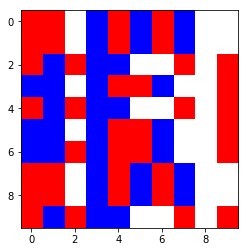

0

In [21]:
print('Configuration 1')
cg3.get_last_plot()

Configuration 2


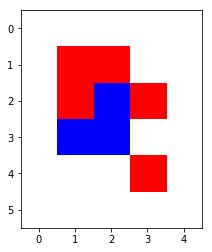

0

In [22]:
print('Configuration 2')
cg2.get_last_plot()

# 4) Module cellular_automaton_manager

Cet objet sert à utiliser l'automate cellulaire à partir d'une console.

Le programme prend en entrée entre 2 et 3 arguments :

- initial_state_path (obligatoire) chemin d'accès vers un fichier au format File/txt/csv contenant une matrice sans header, avec comme delimiter ; (colonne suivante) et \n (ligne suivante).

- transition_matrix_path (obligatoire) chemin d'accès vers un fichier au format File/txt/csv contenant une matrice stochastique ou non de dimension $(n\_spieces^2, n\_spieces^2)$ sans header, avec comme delimiter ; (colonne suivante) et \n (ligne suivante).

- other_params_path (optionnel) pour spécifier les autres paramètres de Cellular_automaton(intial_state, transition_matrix, ...). Doit être au format: 1ère ligne cols;max_range;step_by_step;log_level;log_file_name\n et en ligne 2 les valeurs proposées pour ces arguments par exemple "white,blue,red";10;True;2;'test.log'\n . Le programme prendra les valeurs par défault de Cellular_automaton() en cas de problème sur ce fichier.

Voir les templates pour plus de détails.

Après lecture des fichiers en INPUT (le contrôle des erreurs est fait dans le constructeur de Cellular_automaton ), le programme fait des transitions aléatoires et les affiche sur l'interface graphique de Python jusqu'à arrêt manuel (si max_range = None). Sinon, le programme fait ses transitions puis sort a video.

Exemple de commandes :

Si python est une variable d'environnement :

python path_cellular_automaton_manager.py path_initial_state path_transition_matrix path_other_params.txt

python2 path_cellular_automaton_manager.py path_initial_state path_transition_matrix path_other_params.txt

python3 path_cellular_automaton_manager.py path_initial_state path_transition_matrix path_other_params.txt

Sinon :

path_python.exe path_cellular_automaton_manager.py path_initial_state path_transition_matrix path_other_params.txt

# Sauvegarde pour autres tests

In [15]:
savetxt('initial_statecg1', initial_state3, fmt='%.18e', delimiter=';', newline='\n', header='', footer='', comments='# ', encoding=None)
savetxt('transition_matrixcg1', transition_matrix3, fmt='%.18e', delimiter=';', newline='\n', header='', footer='', comments='# ', encoding=None)

In [16]:
savetxt('initial_statecg2', initial_state2, fmt='%.18e', delimiter=';', newline='\n', header='', footer='', comments='# ', encoding=None)
savetxt('transition_matrixcg2', transition_matrix2, fmt='%.18e', delimiter=';', newline='\n', header='', footer='', comments='# ', encoding=None)